## Final Project Submission

Please fill out:
* Student name: Kai Graham
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
# Predict housing prices to be used by PE shop looking for valuation help.

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# function to perform stepwsise selection
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [4]:
# set style of graphs and visualizations
plt.style.use('ggplot')

In [5]:
# import the dataset
raw_data = pd.read_csv('kc_house_data.csv')

In [6]:
# examine the dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
# drop the id column as that won't be relevant
clean_data = raw_data.drop('id', axis=1)

In [8]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [9]:
# Handle Missing Values
# waterfront, yr_renovated, view

# evaluate waterfront
clean_data['waterfront'].nunique()

2

In [10]:
clean_data['waterfront'].unique()

array([nan,  0.,  1.])

In [11]:
# how many nans are there
clean_data['waterfront'].isna().sum()

2376

In [12]:
# given how many values this is, going to keep data in for now
# set all nans to 0 as houses missing waterfront info likely are not 
# waterfront
clean_data['waterfront'] = clean_data['waterfront'].fillna(value=0.)

In [13]:
# Handle yr_renovated missing values
clean_data['yr_renovated'].nunique()

70

In [14]:
clean_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [15]:
# how many are missing
clean_data['yr_renovated'].isna().sum()

3842

In [16]:
# similar to waterfront, assume missing data are 0's are non-renos
clean_data['yr_renovated'] = clean_data['yr_renovated'].fillna(value=0.)

In [17]:
# Handle view missing values
clean_data['view'].isna().sum()

63

In [18]:
clean_data['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [19]:
# view is the number of times a house has been viewed
# set missing values to 0 with the assumption that missing values have
# no views
clean_data['view'] = clean_data['view'].fillna(value=0.)

In [20]:
# check for remaining missing values
clean_data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [21]:
# no more missing values
# check for duplicates
clean_data.duplicated().sum()

0

In [22]:
# There are no duplicates -- handle strings and convert all columns
# to appropriate d type for regression
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  float64
 8   view           21597 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [23]:
# only string columns are the date and sqft_basement
# evaluate sqft_basement
clean_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [24]:
# replace '?' with zero with assumption that these do not have basements
clean_data['sqft_basement'] = clean_data['sqft_basement'].replace(to_replace='?',
                                                                      value='0.0')

In [25]:
# convert to a number format
clean_data['sqft_basement'] = clean_data['sqft_basement'].astype('float64')

In [26]:
# handle date column - convert to a datetime type and then split year, month, day
clean_data['date'] = pd.to_datetime(clean_data['date'], infer_datetime_format=True)

In [27]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  float64       
 8   view           21597 non-null  float64       
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  float64       
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  float64       
 15  zipcode        2159

In [28]:
# create individual columns for year, month, and day
clean_data['year_sold'] = clean_data['date'].map(lambda x: x.year)
clean_data['month_sold'] = clean_data['date'].map(lambda x: x.month)
clean_data['day_sold'] = clean_data['date'].map(lambda x: x.day)

In [29]:
# drop date column
clean_data = clean_data.drop('date', axis=1)

In [30]:
# now we have handled missing values, duplicates, obvious weird values,
# and changed the types of columns appropriately
# check that columns are looking ok
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   view           21597 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

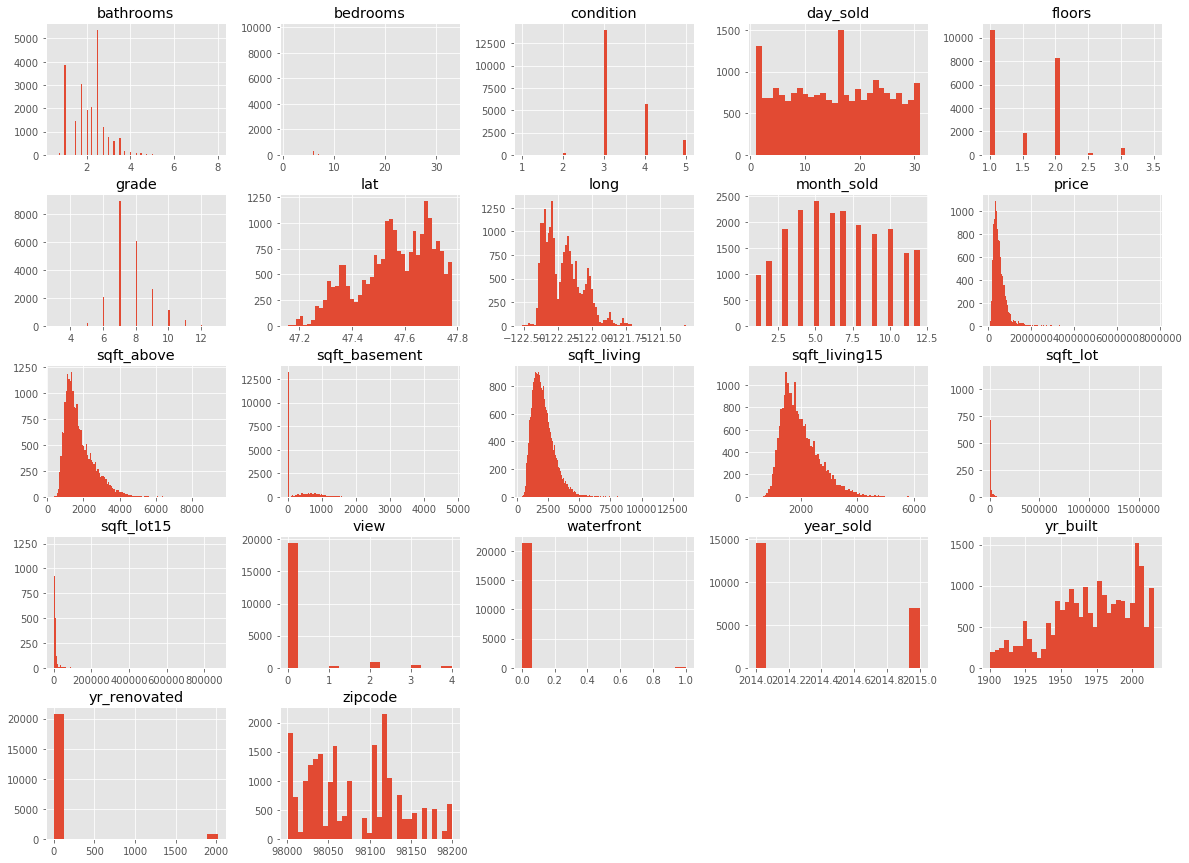

In [31]:
# histograms for all variables
clean_data.hist(figsize=(20,15), bins='auto');

In [32]:
# price, sqft_above, sqft_living, sqft_living15 all appear continuous and log normally distributed
# the majority of houses seem to have less than 4 bathrooms
# most houses have a condition of 3 or higher
# the majority of houses have 2 floors or less
# there are a large number of houses with 0 sqft_basement, likely a result of not having a basement

In [33]:
# evaluate distributions / relationships, etc.
# separate continious and cat variables; remove cont variables that do not meet linearity req
# run a baseline model, evaluate residuals for assumption requirements
# cross fold validation

In [34]:
"""
Function to plot y vs. a chosen set of x variables: includes regression line
"""

def plot_relationship(data, y_vars, x_vars, height=4.5):
    grid = sns.PairGrid(data=data, y_vars=y_vars, x_vars=x_vars, height=height)
    grid.map(sns.regplot)

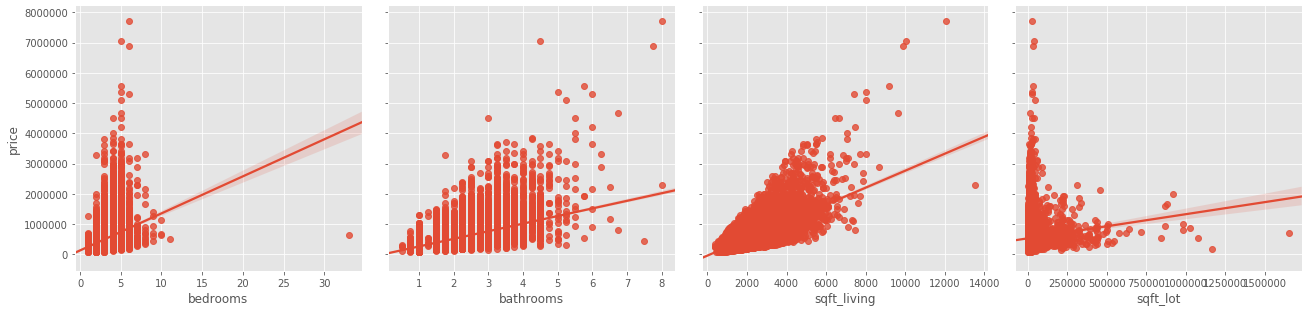

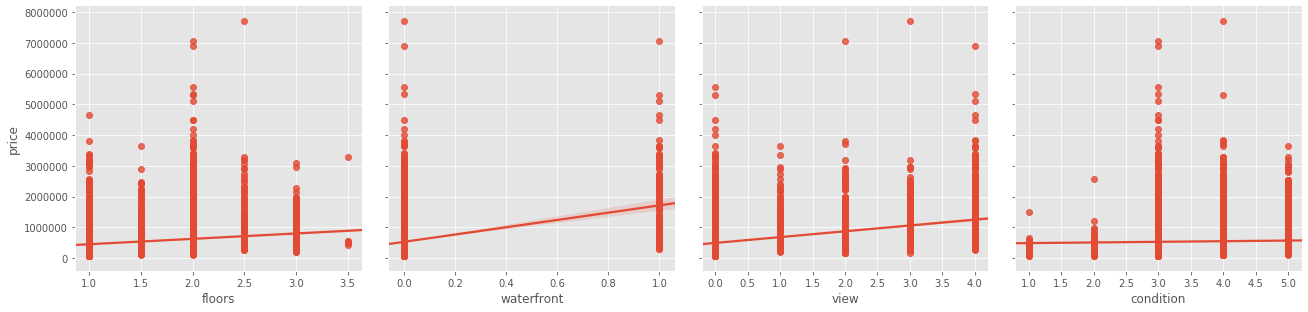

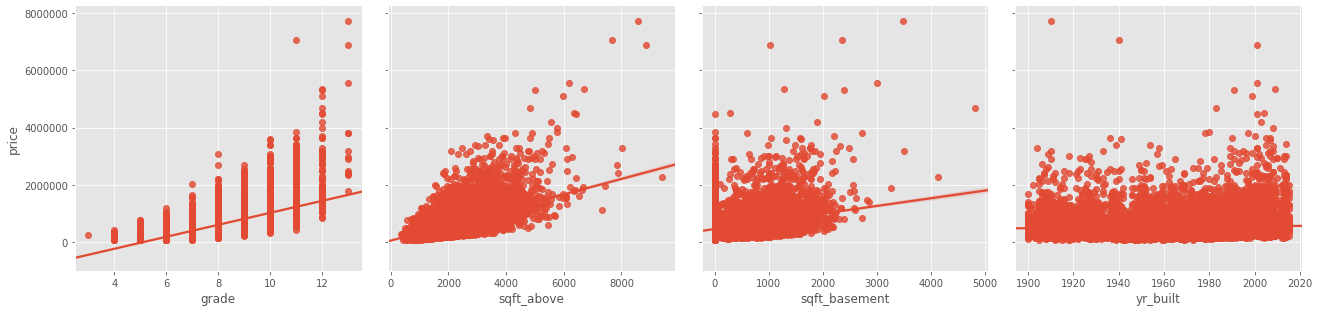

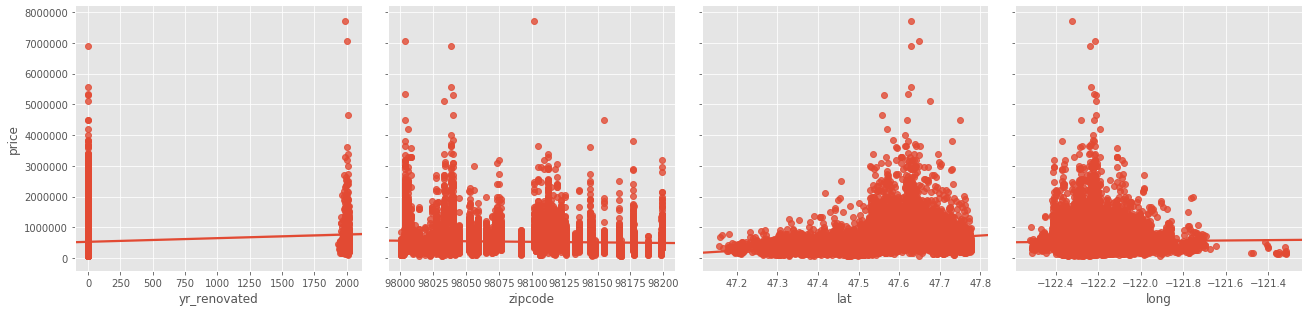

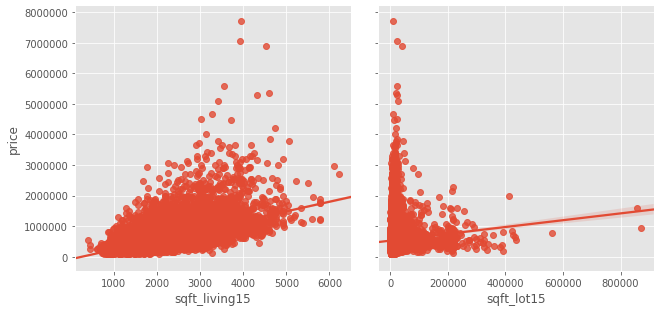

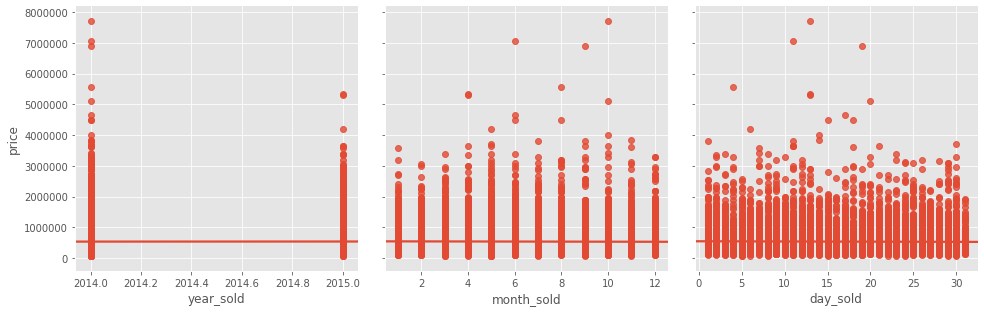

In [35]:
# plot all against price to check linearity assumptions
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['floors', 'waterfront', 'view', 'condition'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['grade', 'sqft_above', 'sqft_basement', 'yr_built'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['yr_renovated', 'zipcode', 'lat', 'long'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['sqft_living15', 'sqft_lot15'])
plot_relationship(data=clean_data, y_vars=['price'], x_vars=['year_sold', 'month_sold', 'day_sold'])

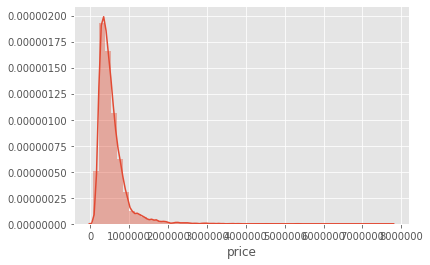

In [36]:
# there are a number of outliers - - it seems many of these are related to abnormally high prices
# look at the distribution of price again
sns.distplot(clean_data['price'])

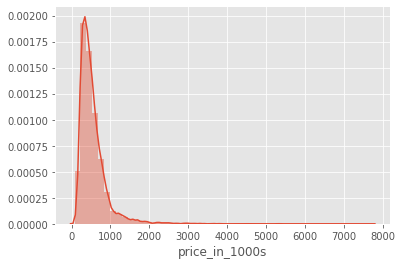

In [37]:
# reduce the scale to make working with price easier - - put into thousands
clean_data['price_in_1000s'] = clean_data['price'] / 1000
sns.distplot(clean_data['price_in_1000s'])

In [38]:
# the majority of values seem to fall under $1M, with a long tail
clean_data['price_in_1000s'].describe()

count    21597.000000
mean       540.296574
std        367.368140
min         78.000000
25%        322.000000
50%        450.000000
75%        645.000000
max       7700.000000
Name: price_in_1000s, dtype: float64

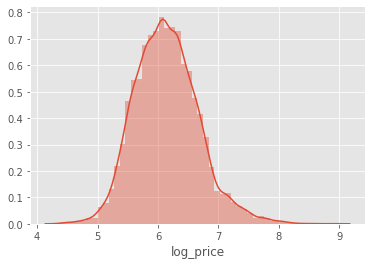

In [39]:
# log transform price as it looks log normally distributed
clean_data['log_price'] = np.log(clean_data['price_in_1000s'])
sns.distplot(clean_data['log_price'])

In [40]:
# looking more normally distributed

In [41]:
# plot all variables agains this

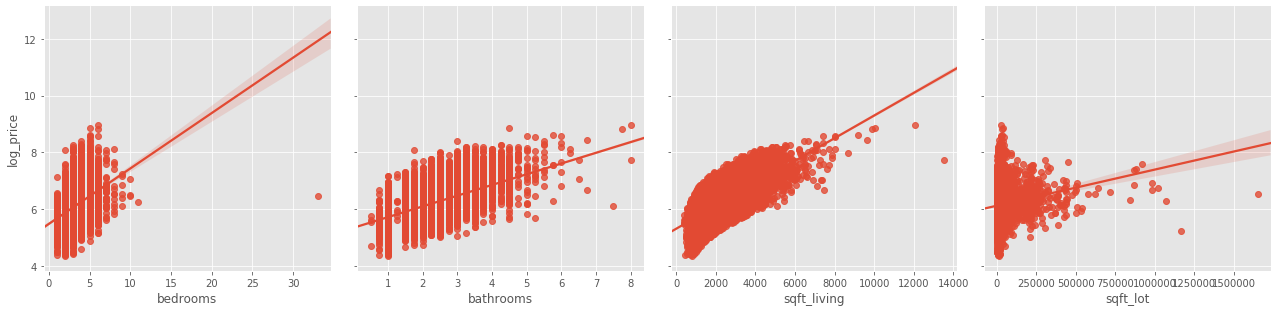

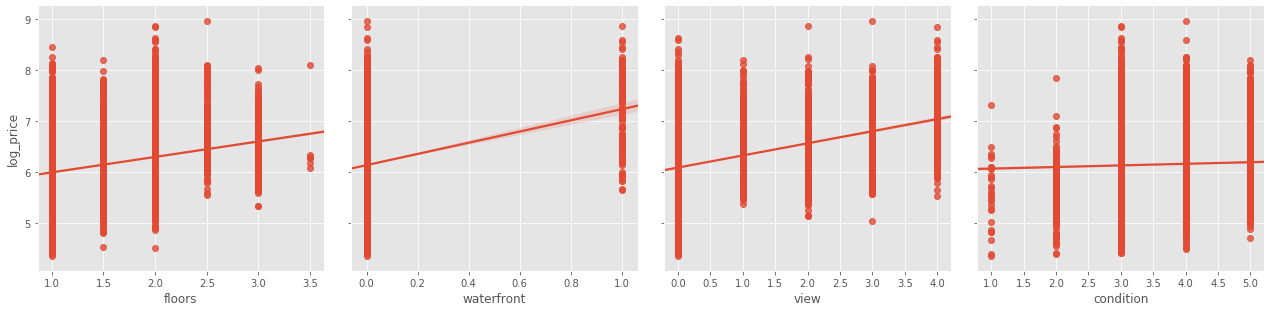

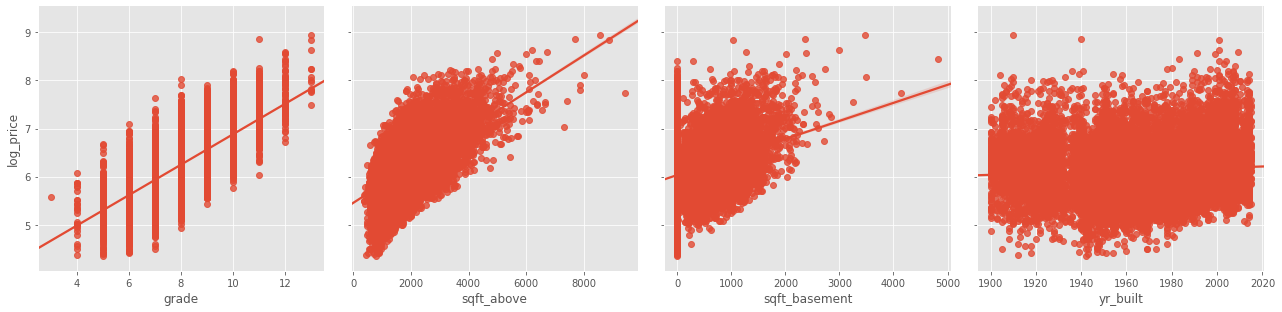

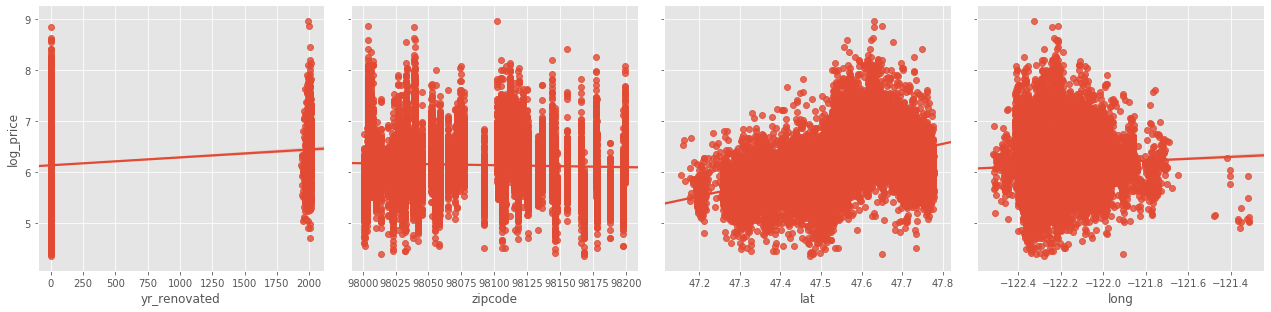

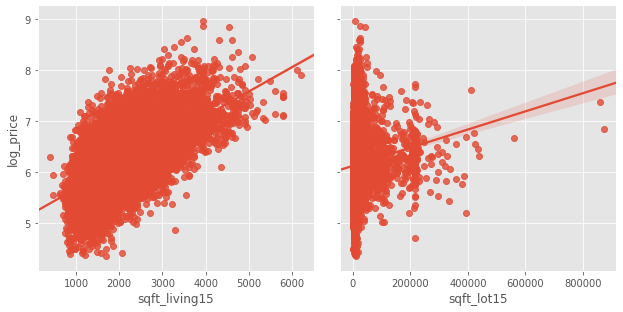

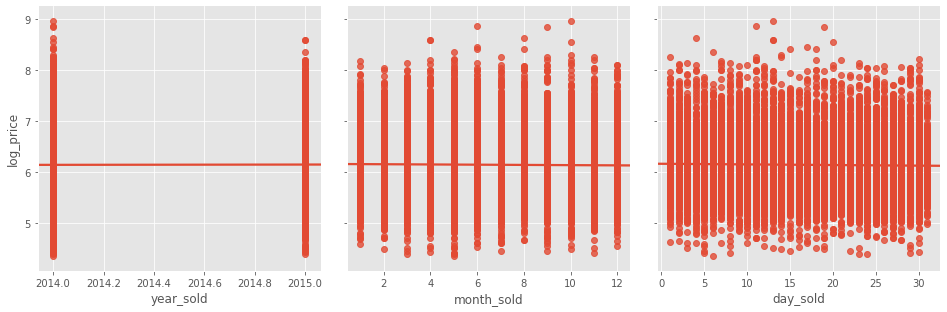

In [42]:
# plot all against price to check linearity assumptions
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'])
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=['floors', 'waterfront', 'view', 'condition'])
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=['grade', 'sqft_above', 'sqft_basement', 'yr_built'])
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=['yr_renovated', 'zipcode', 'lat', 'long'])
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=['sqft_living15', 'sqft_lot15'])
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=['year_sold', 'month_sold', 'day_sold'])

In [43]:
# log transforming price seems to improve linearity between price and grade, sqft_living, sqft_above

In [44]:
# identify categorical and non-cat columns
cat_columns = ['log_price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'year_sold', 
               'month_sold', 'day_sold']

In [45]:
cont_columns = ['log_price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
                'lat', 'long', 'sqft_living15', 'sqft_lot15']
cont_vars = clean_data[cont_columns]

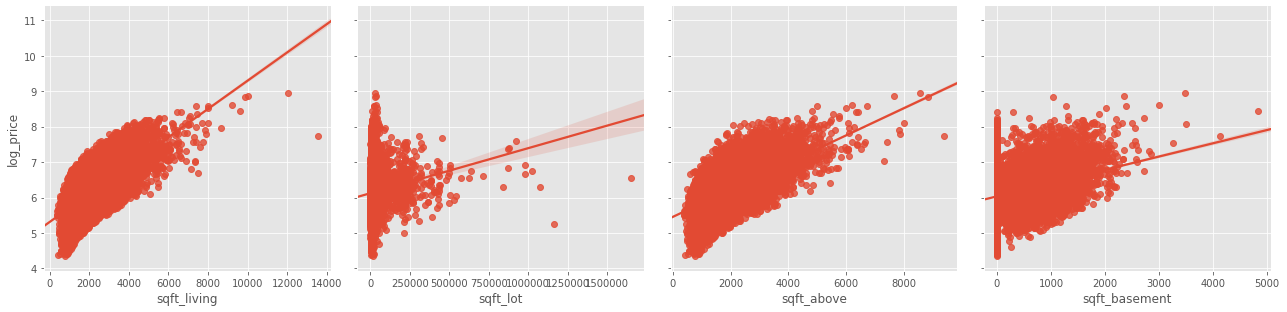

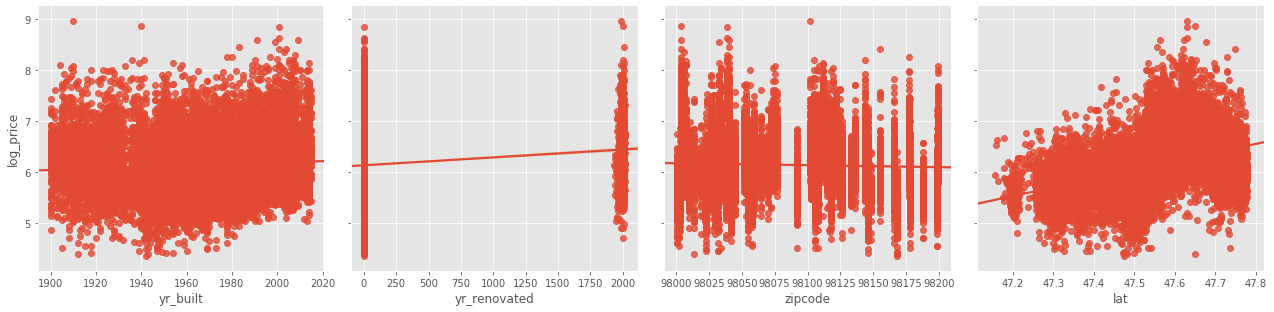

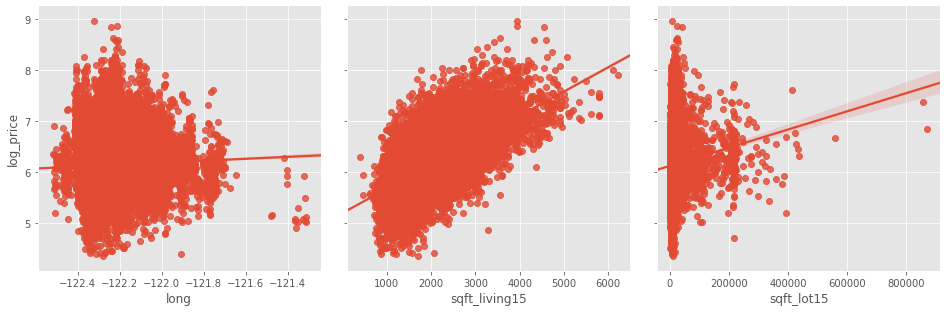

In [46]:
# replot cont vs. price
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'])
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=['yr_built', 'yr_renovated', 'zipcode', 'lat'])
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=['long', 'sqft_living15', 'sqft_lot15'])

In [47]:
# remove clear non-linear columns
clean_data = clean_data.drop(['yr_built', 'yr_renovated', 'zipcode', 'long'], axis=1)
cont_vars = cont_vars.drop(['yr_built', 'yr_renovated', 'zipcode', 'long'], axis=1)

In [48]:
clean_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'lat', 'sqft_living15', 'sqft_lot15', 'year_sold',
       'month_sold', 'day_sold', 'price_in_1000s', 'log_price'],
      dtype='object')

In [49]:
# drop price and price_in_1000s
clean_data = clean_data.drop(['price', 'price_in_1000s'], axis=1)

In [50]:
clean_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'lat', 'sqft_living15', 'sqft_lot15', 'year_sold',
       'month_sold', 'day_sold', 'log_price'],
      dtype='object')

In [51]:
cont_vars.columns

Index(['log_price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'lat', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

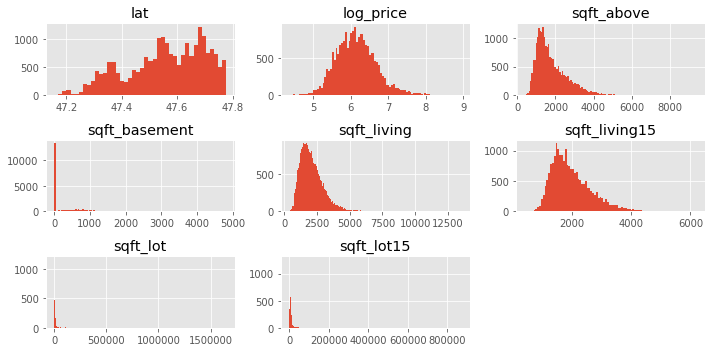

In [52]:
# look at distributions of remaining continuous variables
cont_vars.hist(figsize=(10, 5), bins='auto')
plt.tight_layout()
plt.show()

In [53]:
# log transform sqft_above, sqft_living, sqft_living15 as these look log normally distributed
clean_data['log_sqft_above'] = np.log(clean_data['sqft_above'])
clean_data = clean_data.drop('sqft_above', axis=1)

In [54]:
clean_data['log_sqft_living'] = np.log(clean_data['sqft_living'])
clean_data = clean_data.drop('sqft_living', axis=1)

clean_data['log_sqft_living15'] = np.log(clean_data['sqft_living15'])
clean_data = clean_data.drop('sqft_living15', axis=1)

In [55]:
# replot log transformed variables historgram and against price
log_transformed = clean_data[['log_sqft_above', 'log_sqft_living', 'log_sqft_living15']]

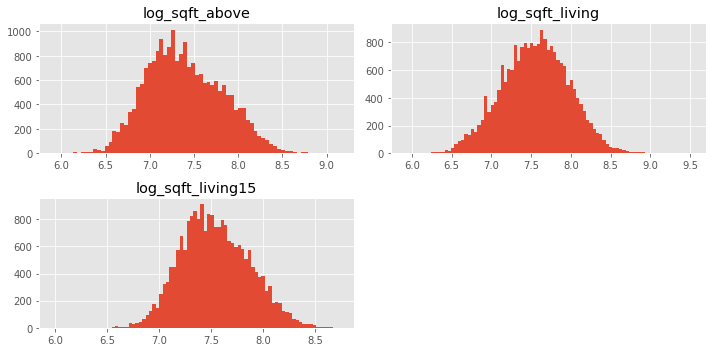

In [56]:
log_transformed.hist(figsize=(10, 5), bins='auto')
plt.tight_layout()
plt.show()

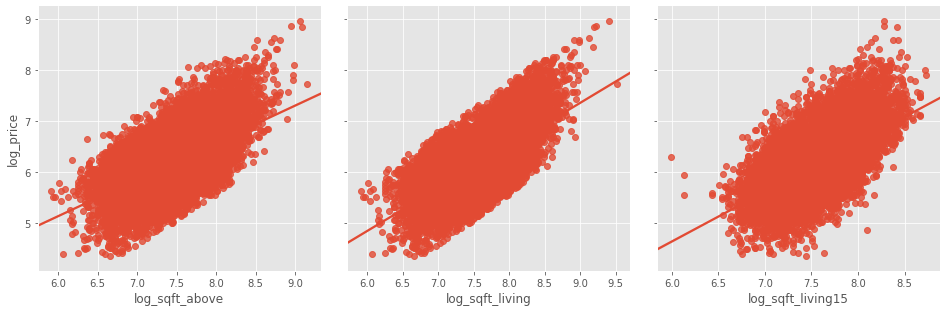

In [57]:
# looking way more normal - - replot against price to see if improved
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=log_transformed.columns)

In [58]:
# looking more linear

In [59]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           21597 non-null  int64  
 1   bathrooms          21597 non-null  float64
 2   sqft_lot           21597 non-null  int64  
 3   floors             21597 non-null  float64
 4   waterfront         21597 non-null  float64
 5   view               21597 non-null  float64
 6   condition          21597 non-null  int64  
 7   grade              21597 non-null  int64  
 8   sqft_basement      21597 non-null  float64
 9   lat                21597 non-null  float64
 10  sqft_lot15         21597 non-null  int64  
 11  year_sold          21597 non-null  int64  
 12  month_sold         21597 non-null  int64  
 13  day_sold           21597 non-null  int64  
 14  log_price          21597 non-null  float64
 15  log_sqft_above     21597 non-null  float64
 16  log_sqft_living    215

In [60]:
data_pred = clean_data.drop('log_price', axis=1)

In [61]:
# remove multi collinearity
# return only highly correlated pairs
# save absolute value of correlation matrix as data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

#zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

#set index to pairs
df.set_index(['pairs'], inplace=True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)

In [62]:
# get pairs that are more than 75% correlated
df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(log_sqft_living, log_sqft_above)",0.864979
"(year_sold, month_sold)",0.782325
"(bathrooms, log_sqft_living)",0.762135


In [63]:
# log_sqft_living is correlated with log_sqft_above, bathrooms - remove log_sqft_above, bathrooms
# remove month_sold
clean_data = clean_data.drop(['log_sqft_above', 'bathrooms', 'month_sold'], axis=1)

In [64]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           21597 non-null  int64  
 1   sqft_lot           21597 non-null  int64  
 2   floors             21597 non-null  float64
 3   waterfront         21597 non-null  float64
 4   view               21597 non-null  float64
 5   condition          21597 non-null  int64  
 6   grade              21597 non-null  int64  
 7   sqft_basement      21597 non-null  float64
 8   lat                21597 non-null  float64
 9   sqft_lot15         21597 non-null  int64  
 10  year_sold          21597 non-null  int64  
 11  day_sold           21597 non-null  int64  
 12  log_price          21597 non-null  float64
 13  log_sqft_living    21597 non-null  float64
 14  log_sqft_living15  21597 non-null  float64
dtypes: float64(8), int64(7)
memory usage: 2.5 MB


In [65]:
log_transformed.columns

Index(['log_sqft_above', 'log_sqft_living', 'log_sqft_living15'], dtype='object')

In [66]:
log_transformed = log_transformed.drop('log_sqft_above', axis=1)

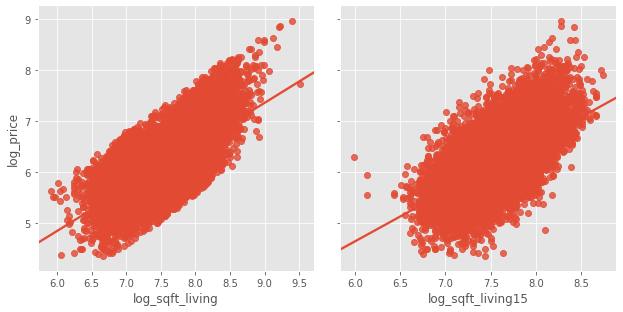

In [67]:
# replot linear
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=log_transformed.columns)

In [68]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           21597 non-null  int64  
 1   sqft_lot           21597 non-null  int64  
 2   floors             21597 non-null  float64
 3   waterfront         21597 non-null  float64
 4   view               21597 non-null  float64
 5   condition          21597 non-null  int64  
 6   grade              21597 non-null  int64  
 7   sqft_basement      21597 non-null  float64
 8   lat                21597 non-null  float64
 9   sqft_lot15         21597 non-null  int64  
 10  year_sold          21597 non-null  int64  
 11  day_sold           21597 non-null  int64  
 12  log_price          21597 non-null  float64
 13  log_sqft_living    21597 non-null  float64
 14  log_sqft_living15  21597 non-null  float64
dtypes: float64(8), int64(7)
memory usage: 2.5 MB


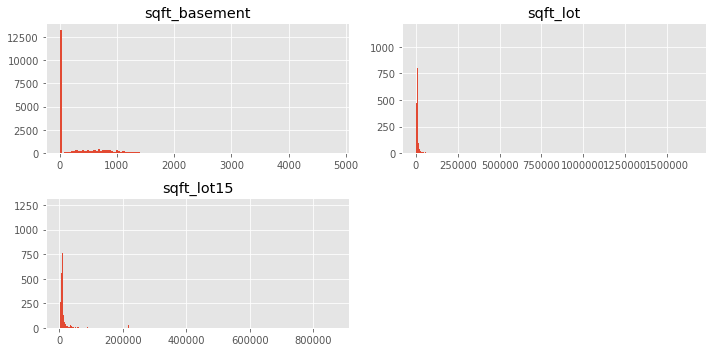

In [69]:
# relationships are looking far more linear now
# handle other continuous variables
remaining_cont = clean_data[['sqft_lot', 'sqft_lot15', 'sqft_basement']]
remaining_cont.hist(figsize=(10, 5), bins='auto')
plt.tight_layout()
plt.show()

In [70]:
# look at sqft_lot and sqft_lot15 first given they don't have massive 0s
clean_data['sqft_lot'].describe()

count    2.159700e+04
mean     1.509941e+04
std      4.141264e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068500e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [71]:
# get cutoff point for outliers
iqr = clean_data['sqft_lot'].quantile(0.75) - clean_data['sqft_lot'].quantile(0.25)
cutoff = iqr + (1.5 * iqr)
cutoff

14112.5

In [72]:
# remove outliers
clean_data = clean_data.loc[clean_data['sqft_lot'] < cutoff]

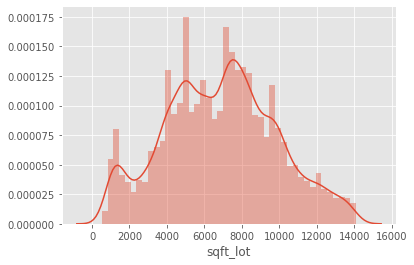

In [73]:
# look at hist
sns.distplot(clean_data['sqft_lot'])

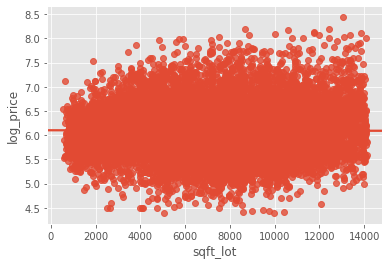

In [74]:
# slightly trimodal, but looking fairly normal
# plot against log_price
sns.regplot(x='sqft_lot', y='log_price', data=clean_data)

In [75]:
# looking more linear now
# handle sqft_lot15
clean_data['sqft_lot15'].describe()

count     18117.000000
mean       6970.264282
std        3690.112629
min         651.000000
25%        4867.000000
50%        7085.000000
75%        8700.000000
max      196591.000000
Name: sqft_lot15, dtype: float64

In [76]:
# get cutoff point and remove outliers
iqr = clean_data['sqft_lot15'].quantile(0.75) - clean_data['sqft_lot15'].quantile(0.25)
cutoff = iqr + (1.5 * iqr)
cutoff

9582.5

In [77]:
clean_data = clean_data.loc[clean_data['sqft_lot15'] < cutoff]

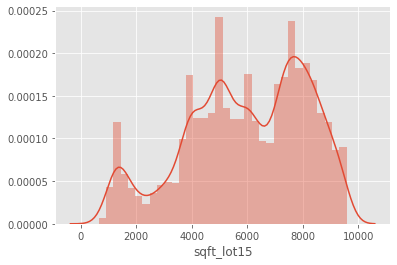

In [78]:
# look at hist again
sns.distplot(clean_data['sqft_lot15'])

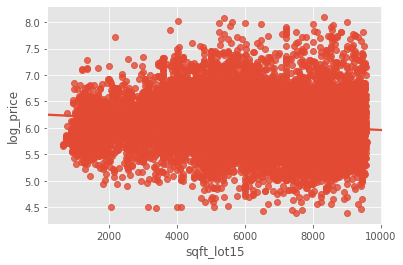

In [79]:
# again, not super normal, but looking better without outliers
# compare to price to check linearity
sns.regplot(x='sqft_lot15', y='log_price', data=clean_data)

In [80]:
# looking more linear now

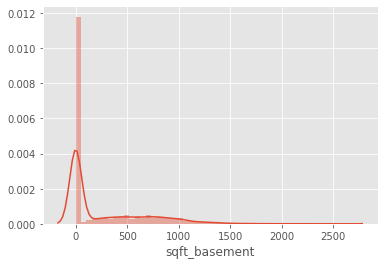

In [81]:
# handle sqft_basement
sns.distplot(clean_data['sqft_basement'])

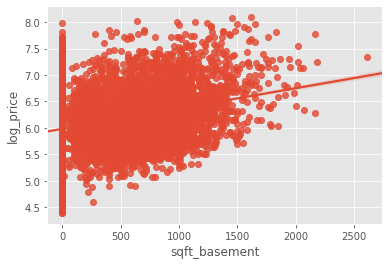

In [82]:
# plot against log_price
sns.regplot(x='sqft_basement', y='log_price', data=clean_data)

In [83]:
# bimodal, with a lot of zeros
# doesn't meet linearity requirement - - remove for now
# after baseline model, come back and OHE to see if having a basement is better than not
clean_data = clean_data.drop('sqft_basement', axis=1)

In [84]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14913 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           14913 non-null  int64  
 1   sqft_lot           14913 non-null  int64  
 2   floors             14913 non-null  float64
 3   waterfront         14913 non-null  float64
 4   view               14913 non-null  float64
 5   condition          14913 non-null  int64  
 6   grade              14913 non-null  int64  
 7   lat                14913 non-null  float64
 8   sqft_lot15         14913 non-null  int64  
 9   year_sold          14913 non-null  int64  
 10  day_sold           14913 non-null  int64  
 11  log_price          14913 non-null  float64
 12  log_sqft_living    14913 non-null  float64
 13  log_sqft_living15  14913 non-null  float64
dtypes: float64(7), int64(7)
memory usage: 1.7 MB


In [85]:
# cont vars meeting linearity requirement
linearity_requirement = ['sqft_lot', 'lat', 'sqft_lot15', 'log_sqft_living', 'log_sqft_living15']

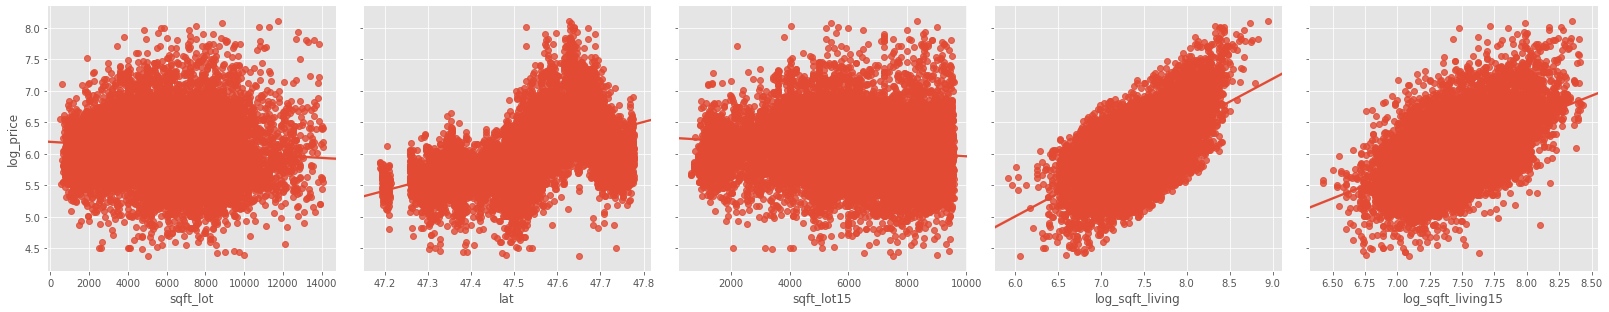

In [86]:
# plot against price to double check linearity
plot_relationship(data=clean_data, y_vars=['log_price'], x_vars=linearity_requirement)

In [87]:
# remove lat - - doesn't meet linearity, leave all others in for now
clean_data = clean_data.drop('lat', axis=1)
linearity_requirement = ['sqft_lot', 'sqft_lot15', 'log_sqft_living', 'log_sqft_living15']

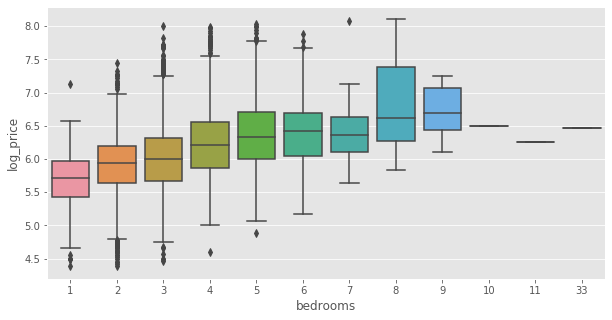

In [88]:
# handle categorical columns
# first will need to identify which categorical columns have an ordinal relationship with price
# plot boxplots of each cat variable to see if it is ordinal or not

# Bedrooms
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='bedrooms', y='log_price', data=clean_data)
plt.show()

In [89]:
# there appears to be an ordinal relationship here, leave as single column
# handle outliers
clean_data['bedrooms'].describe()

count    14913.000000
mean         3.297660
std          0.938266
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

In [90]:
# how many entries with more than 5 bedrooms?
clean_data.loc[clean_data['bedrooms'] > 5]['log_price'].count()

206

In [91]:
clean_data.loc[clean_data['bedrooms'] > 5]['log_price'].count() / len(clean_data)

0.01381345135117012

In [92]:
# less than 1.5% - - remove these outliers
clean_data = clean_data.loc[clean_data['bedrooms'] <= 5]

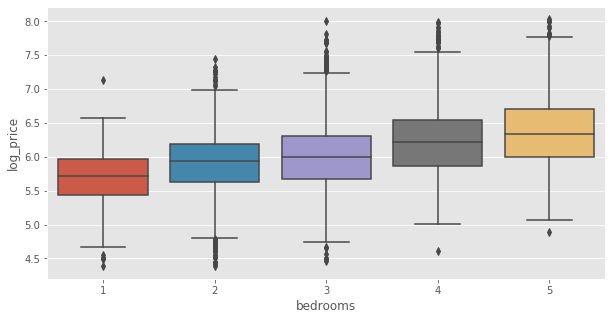

In [93]:
# replot against price
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='bedrooms', y='log_price', data=clean_data)
plt.show()

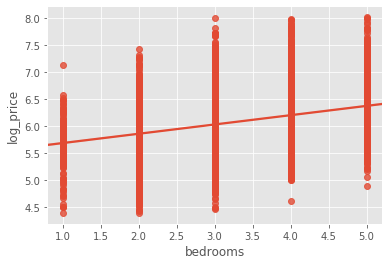

In [94]:
# plot against price without box plots
sns.regplot(x='bedrooms', y='log_price', data=clean_data)
plt.show()

In [95]:
# this is ordinal, and appears to meet linearity requirements

In [96]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14707 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           14707 non-null  int64  
 1   sqft_lot           14707 non-null  int64  
 2   floors             14707 non-null  float64
 3   waterfront         14707 non-null  float64
 4   view               14707 non-null  float64
 5   condition          14707 non-null  int64  
 6   grade              14707 non-null  int64  
 7   sqft_lot15         14707 non-null  int64  
 8   year_sold          14707 non-null  int64  
 9   day_sold           14707 non-null  int64  
 10  log_price          14707 non-null  float64
 11  log_sqft_living    14707 non-null  float64
 12  log_sqft_living15  14707 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 2.2 MB


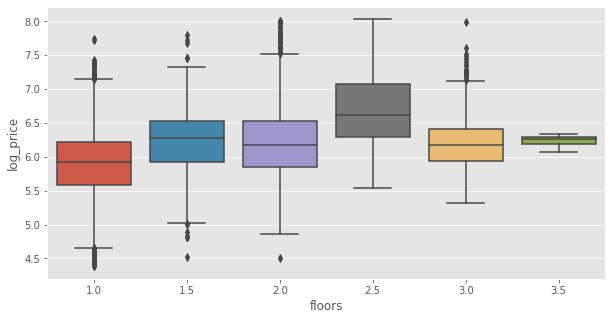

In [97]:
# floors
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='floors', y='log_price', data=clean_data)
plt.show()

In [98]:
clean_data['floors'].describe()

count    14707.000000
mean         1.527402
std          0.558368
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [99]:
# no major outliers -- not ordinal, will OHE

In [100]:
# scale by 10 and then ohe -- .0 will mess up smf.ols
clean_data['floors'] = clean_data['floors'] * 10

# convert to int
clean_data['floors'] = clean_data['floors'].astype('int64')

In [101]:
ohe_list = []
ohe_list.append('floors')

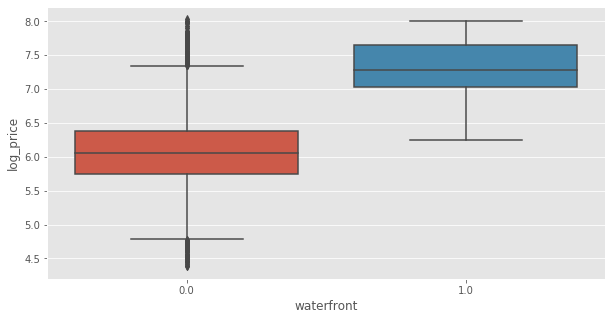

In [102]:
# waterfront
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='waterfront', y='log_price', data=clean_data)
plt.show()

In [103]:
# convert to int to avoid syntax issues with smf.ols
clean_data['waterfront_clean'] = clean_data['waterfront'].astype('int64')

# drop waterfront column
clean_data = clean_data.drop('waterfront', axis=1)

In [104]:
# CREATE DUMMY
ohe_list.append('waterfront_clean')

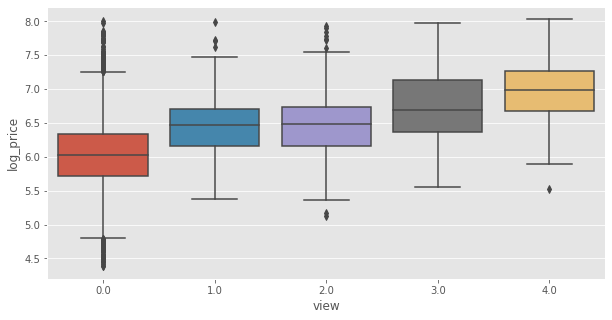

In [105]:
# view
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='view', y='log_price', data=clean_data)
plt.show()

In [106]:
# slight ordinal relationship, leave as a single column for now
clean_data['view'].describe()

count    14707.000000
mean         0.161284
std          0.623960
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

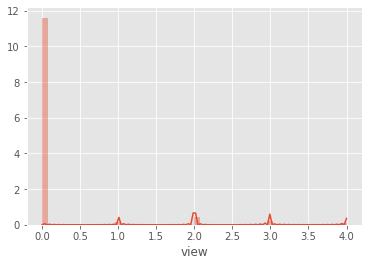

In [107]:
sns.distplot(clean_data['view'])

In [108]:
# how many houses have been viewed more than 0
clean_data.loc[clean_data['view'] > 0]['log_price'].count()

1049

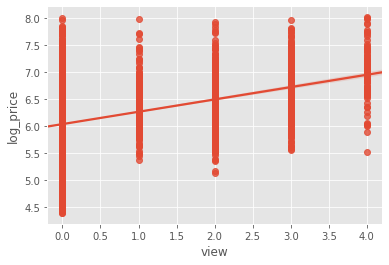

In [109]:
sns.regplot(x='view', y='log_price', data=clean_data)

In [110]:
# similar to sqft_basement going to leave out for now
clean_data = clean_data.drop('view', axis=1)

In [111]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14707 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           14707 non-null  int64  
 1   sqft_lot           14707 non-null  int64  
 2   floors             14707 non-null  int64  
 3   condition          14707 non-null  int64  
 4   grade              14707 non-null  int64  
 5   sqft_lot15         14707 non-null  int64  
 6   year_sold          14707 non-null  int64  
 7   day_sold           14707 non-null  int64  
 8   log_price          14707 non-null  float64
 9   log_sqft_living    14707 non-null  float64
 10  log_sqft_living15  14707 non-null  float64
 11  waterfront_clean   14707 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 2.1 MB


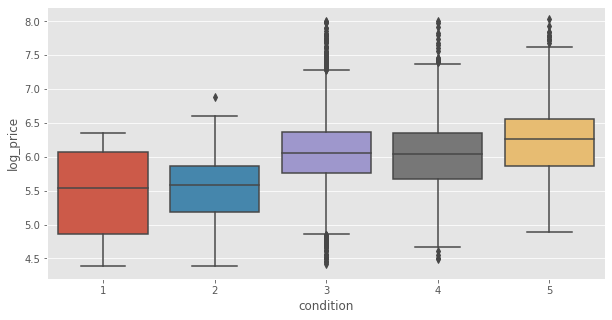

In [112]:
# condition
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='condition', y='log_price', data=clean_data)
plt.show()

In [113]:
# no clear ordinal relationship
# CREATE DUMMY
ohe_list.append('condition')

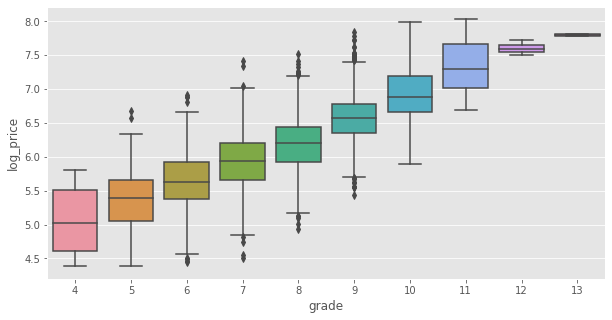

In [114]:
# grade
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='grade', y='log_price', data=clean_data)
plt.show()

In [115]:
# clear ordinal relationship
# look at outliers
clean_data['grade'].describe()

count    14707.000000
mean         7.469504
std          0.990471
min          4.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

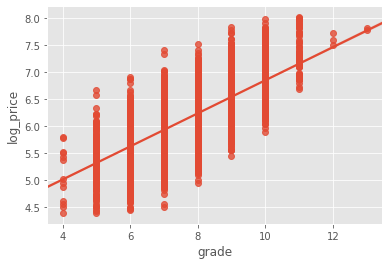

In [116]:
# leaving this as a single column
sns.regplot(x='grade', y='log_price', data=clean_data)

In [117]:
# how many entries with a higher grade than 10?
clean_data.loc[clean_data['grade'] > 10]['log_price'].count()

75

In [118]:
# only 75 are greater than 10 - - drop these
clean_data = clean_data.loc[clean_data['grade'] <= 10]

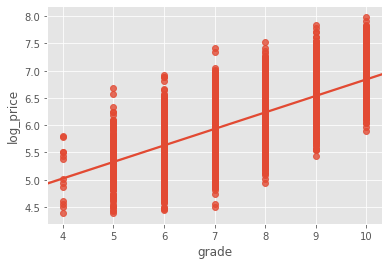

In [119]:
sns.regplot(x='grade', y='log_price', data=clean_data)

In [120]:
# how many received a grade less than 5?
clean_data.loc[clean_data['grade'] < 5]['log_price'].count()

13

In [121]:
# remove these
clean_data = clean_data.loc[clean_data['grade'] >= 5]

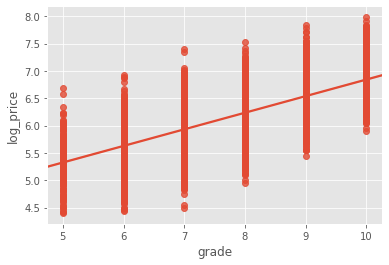

In [122]:
sns.regplot(x='grade', y='log_price', data=clean_data)

In [123]:
# meets linearity

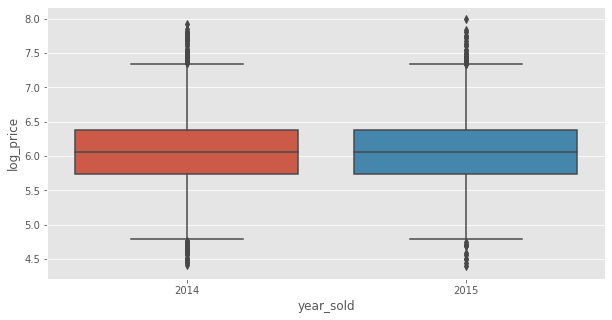

In [124]:
# year_sold
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='year_sold', y='log_price', data=clean_data)
plt.show()

In [125]:
# OHE
ohe_list.append('year_sold')

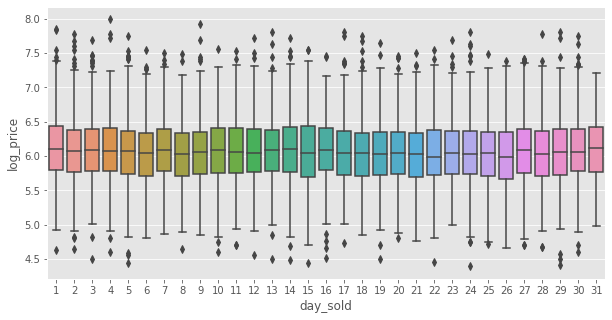

In [126]:
# day_sold
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='day_sold', y='log_price', data=clean_data)
plt.show()

In [127]:
# OHE
ohe_list.append('day_sold')

In [128]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14619 entries, 0 to 21596
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           14619 non-null  int64  
 1   sqft_lot           14619 non-null  int64  
 2   floors             14619 non-null  int64  
 3   condition          14619 non-null  int64  
 4   grade              14619 non-null  int64  
 5   sqft_lot15         14619 non-null  int64  
 6   year_sold          14619 non-null  int64  
 7   day_sold           14619 non-null  int64  
 8   log_price          14619 non-null  float64
 9   log_sqft_living    14619 non-null  float64
 10  log_sqft_living15  14619 non-null  float64
 11  waterfront_clean   14619 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 2.1 MB


In [129]:
ohe_list

['floors', 'waterfront_clean', 'condition', 'year_sold', 'day_sold']

In [130]:
floor_dummies = pd.get_dummies(clean_data['floors'], prefix='floors', drop_first=True)
waterfront_dummies = pd.get_dummies(clean_data['waterfront_clean'], prefix='waterfront', drop_first=True)
condition_dummies = pd.get_dummies(clean_data['condition'], prefix='condition', drop_first=True)
year_sold_dummies = pd.get_dummies(clean_data['year_sold'], prefix='year_sold', drop_first=True)
day_sold_dummies = pd.get_dummies(clean_data['day_sold'], prefix='day_sold', drop_first=True)

In [131]:
# concat with dummies and drop cat columns
preprocessed = pd.concat([clean_data, floor_dummies, waterfront_dummies,
                          condition_dummies, year_sold_dummies, day_sold_dummies], axis=1)

# drop
preprocessed = preprocessed.drop(['floors', 'waterfront_clean', 'condition', 'year_sold', 'day_sold'], axis=1)

In [132]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14619 entries, 0 to 21596
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           14619 non-null  int64  
 1   sqft_lot           14619 non-null  int64  
 2   grade              14619 non-null  int64  
 3   sqft_lot15         14619 non-null  int64  
 4   log_price          14619 non-null  float64
 5   log_sqft_living    14619 non-null  float64
 6   log_sqft_living15  14619 non-null  float64
 7   floors_15          14619 non-null  uint8  
 8   floors_20          14619 non-null  uint8  
 9   floors_25          14619 non-null  uint8  
 10  floors_30          14619 non-null  uint8  
 11  floors_35          14619 non-null  uint8  
 12  waterfront_1       14619 non-null  uint8  
 13  condition_2        14619 non-null  uint8  
 14  condition_3        14619 non-null  uint8  
 15  condition_4        14619 non-null  uint8  
 16  condition_5        146

In [133]:
# run stepwise selection to select features
y = preprocessed['log_price']
X = preprocessed.drop('log_price', axis=1)

result = stepwise_selection(X, y, verbose = True)

Add  grade                          with p-value 0.0


/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  log_sqft_living                with p-value 4.90607e-277
Add  sqft_lot15                     with p-value 9.78005e-170
Add  floors_20                      with p-value 1.28485e-184
Add  condition_3                    with p-value 2.52579e-89
Add  log_sqft_living15              with p-value 1.20072e-72
Add  floors_15                      with p-value 1.97855e-41
Add  condition_5                    with p-value 3.21875e-29
Add  bedrooms                       with p-value 6.14191e-22
Add  waterfront_1                   with p-value 7.33236e-20
Add  floors_30                      with p-value 1.30247e-18
Add  year_sold_2015                 with p-value 1.2789e-10
Add  condition_4                    with p-value 1.2607e-08
Add  sqft_lot                       with p-value 1.28179e-07
Add  day_sold_26                    with p-value 0.000144516


In [134]:
result

['grade',
 'log_sqft_living',
 'sqft_lot15',
 'floors_20',
 'condition_3',
 'log_sqft_living15',
 'floors_15',
 'condition_5',
 'bedrooms',
 'waterfront_1',
 'floors_30',
 'year_sold_2015',
 'condition_4',
 'sqft_lot',
 'day_sold_26']

In [137]:
# run regression with these features
X = preprocessed[result]
y = preprocessed['log_price']
predictors = sm.add_constant(X)

model = sm.OLS(y, predictors).fit()

In [138]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     1131.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:15:04   Log-Likelihood:                -4036.2
No. Observations:               14619   AIC:                             8104.
Df Residuals:                   14603   BIC:                             8226.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1805      0.091     -1.991      0.046      -0.358      -0.003
grade                 0.2044      0.004     47.928      0.000       0.196       0.213
log_sqft_living       0.4416      0.013     33.057      0.000       0.415       0.468
sqft_lot15        -4.309e-05   2.49e-06    -17.311      0.000    -4.8e-05   -3.82e-05
floors_20            -0.1794      0.008    -23.741      0.000      -0.194      -0.165
condition_3           0.0775      0.030      2.566      0.010       0.018       0.137
log_sqft_living15     0.2441      0.014     17.629      0.000       0.217       0.271
floors_15             0.1202      0.010     12.395      0.000       0.101       0.139
condition_5           0.2875      0.031      9.168      0.000       0.226       0.349
bedrooms             -0.0407      0.004     -9.282      0.000      -0.049      -0.032
waterfront_1          0.7427      0.080      9.292      0.000       0.586       0.899
floors_30            -0.1493      0.016     -9.318      0.000      -0.181      -0.118
year_sold_2015        0.0374      0.006      6.616      0.000       0.026       0.048
condition_4           0.1708      0.030      5.619      0.000       0.111       0.230
sqft_lot          -1.125e-05   2.13e-06     -5.281      0.000   -1.54e-05   -7.07e-06
day_sold_26          -0.0591      0.016     -3.801      0.000      -0.090      -0.029
==============================================================================
Omnibus:                        4.455   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                4.426
Skew:                          -0.041   Prob(JB):                        0.109
Kurtosis:                       3.023   Cond. No.                     3.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""